# Time Series

Alban PEREIRA BGD

## Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import signal
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

## Données "Syndrômes grippaux"

### Question 1

In [2]:
# Importer les données du csv
data = pd.read_csv('data/Openhealth_S-Grippal.csv', sep=';')

# Afficher les 5 premières lignes
data.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,"1,7","2,2","2,3"
1,2009-07-02,"3,4","2,1","2,3"
2,2009-07-03,"2,1","2,1","2,3"
3,2009-07-04,"1,3",2,"2,3"
4,2009-07-05,"14,2",2,"2,3"


In [3]:
# Remplacer les virgules par des points dans 'IAS_brut' et convertir en numérique
data['IAS_brut'] = data['IAS_brut'].str.replace(',', '.').astype(float)

# Vérifier le nombre de valeurs nulles ou manquantes dans 'IAS_brut'
missing_values_count = data[data['IAS_brut']==0.0].count()

# Remplacer les valeurs nulles par une interpolation linéaire
data.loc[data['IAS_brut'] == 0.0, 'IAS_brut'] = np.nan
data['IAS_brut'] = data['IAS_brut'].interpolate()

# Affichage du nombre de valeurs nulles ou manquantes dans 'IAS_brut'
missing_values_count

PERIODE                  8
IAS_brut                 8
IAS_lisse                8
Incidence_Sentinelles    8
dtype: int64

In [4]:
# Convertir la colonne 'PERIODE' en datetime pour travailler avec une série temporelle
data['PERIODE'] = pd.to_datetime(data['PERIODE'])

# Déterminer les dates de début et de fin de la série temporelle
start_date = data['PERIODE'].min()
end_date = data['PERIODE'].max()
print("Date de début de la série temporelle : ", start_date, "\nDate de fin de la série temporelle : ", end_date)

# Fréquence d'échantillonnage
sampling_frequency = data['PERIODE'].diff().mode()[0]  # Le mode de la différence donne la fréquence la plus commune
print("Fréquence d'échantillonnage : ", sampling_frequency)

Date de début de la série temporelle :  2009-07-01 00:00:00 
Date de fin de la série temporelle :  2014-04-17 00:00:00
Fréquence d'échantillonnage :  1 days 00:00:00


In [5]:
# Afficher les 5 premières lignes du jeu de données
data.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,"2,2","2,3"
1,2009-07-02,3.4,"2,1","2,3"
2,2009-07-03,2.1,"2,1","2,3"
3,2009-07-04,1.3,2,"2,3"
4,2009-07-05,14.2,2,"2,3"


### Question 2

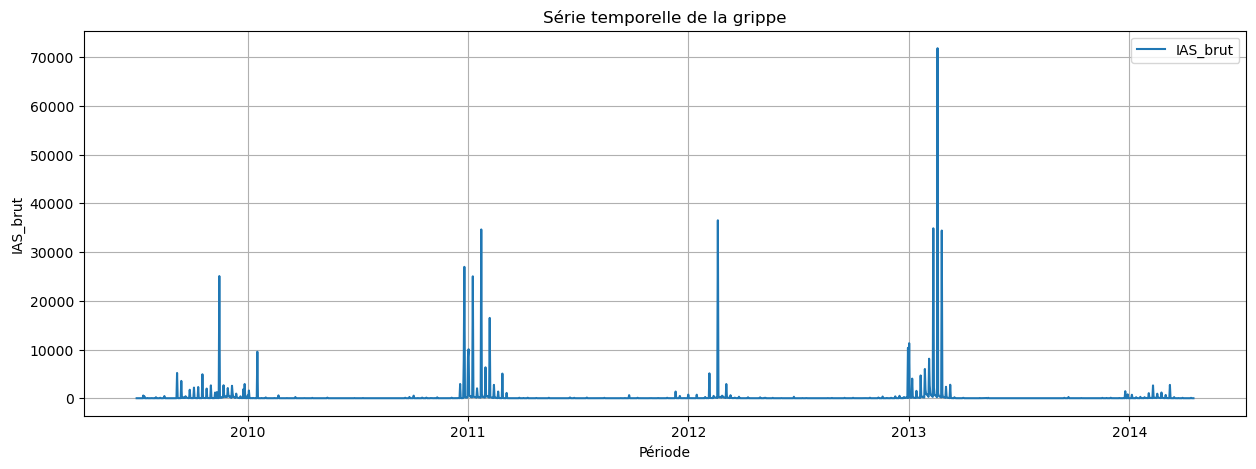

In [14]:
# Tracer la série temporelle en fonction de la période
plt.figure(figsize=(15, 5))
plt.plot(data['PERIODE'], data['IAS_brut'], label='IAS_brut')
plt.title('Série temporelle de la grippe')
plt.xlabel('Période')
plt.ylabel('IAS_brut')
plt.legend()
plt.grid(True)
plt.show()

![Capture d’écran 2024-03-22 à 09.03.55.png](<attachment:Capture d’écran 2024-03-22 à 09.03.55.png>)
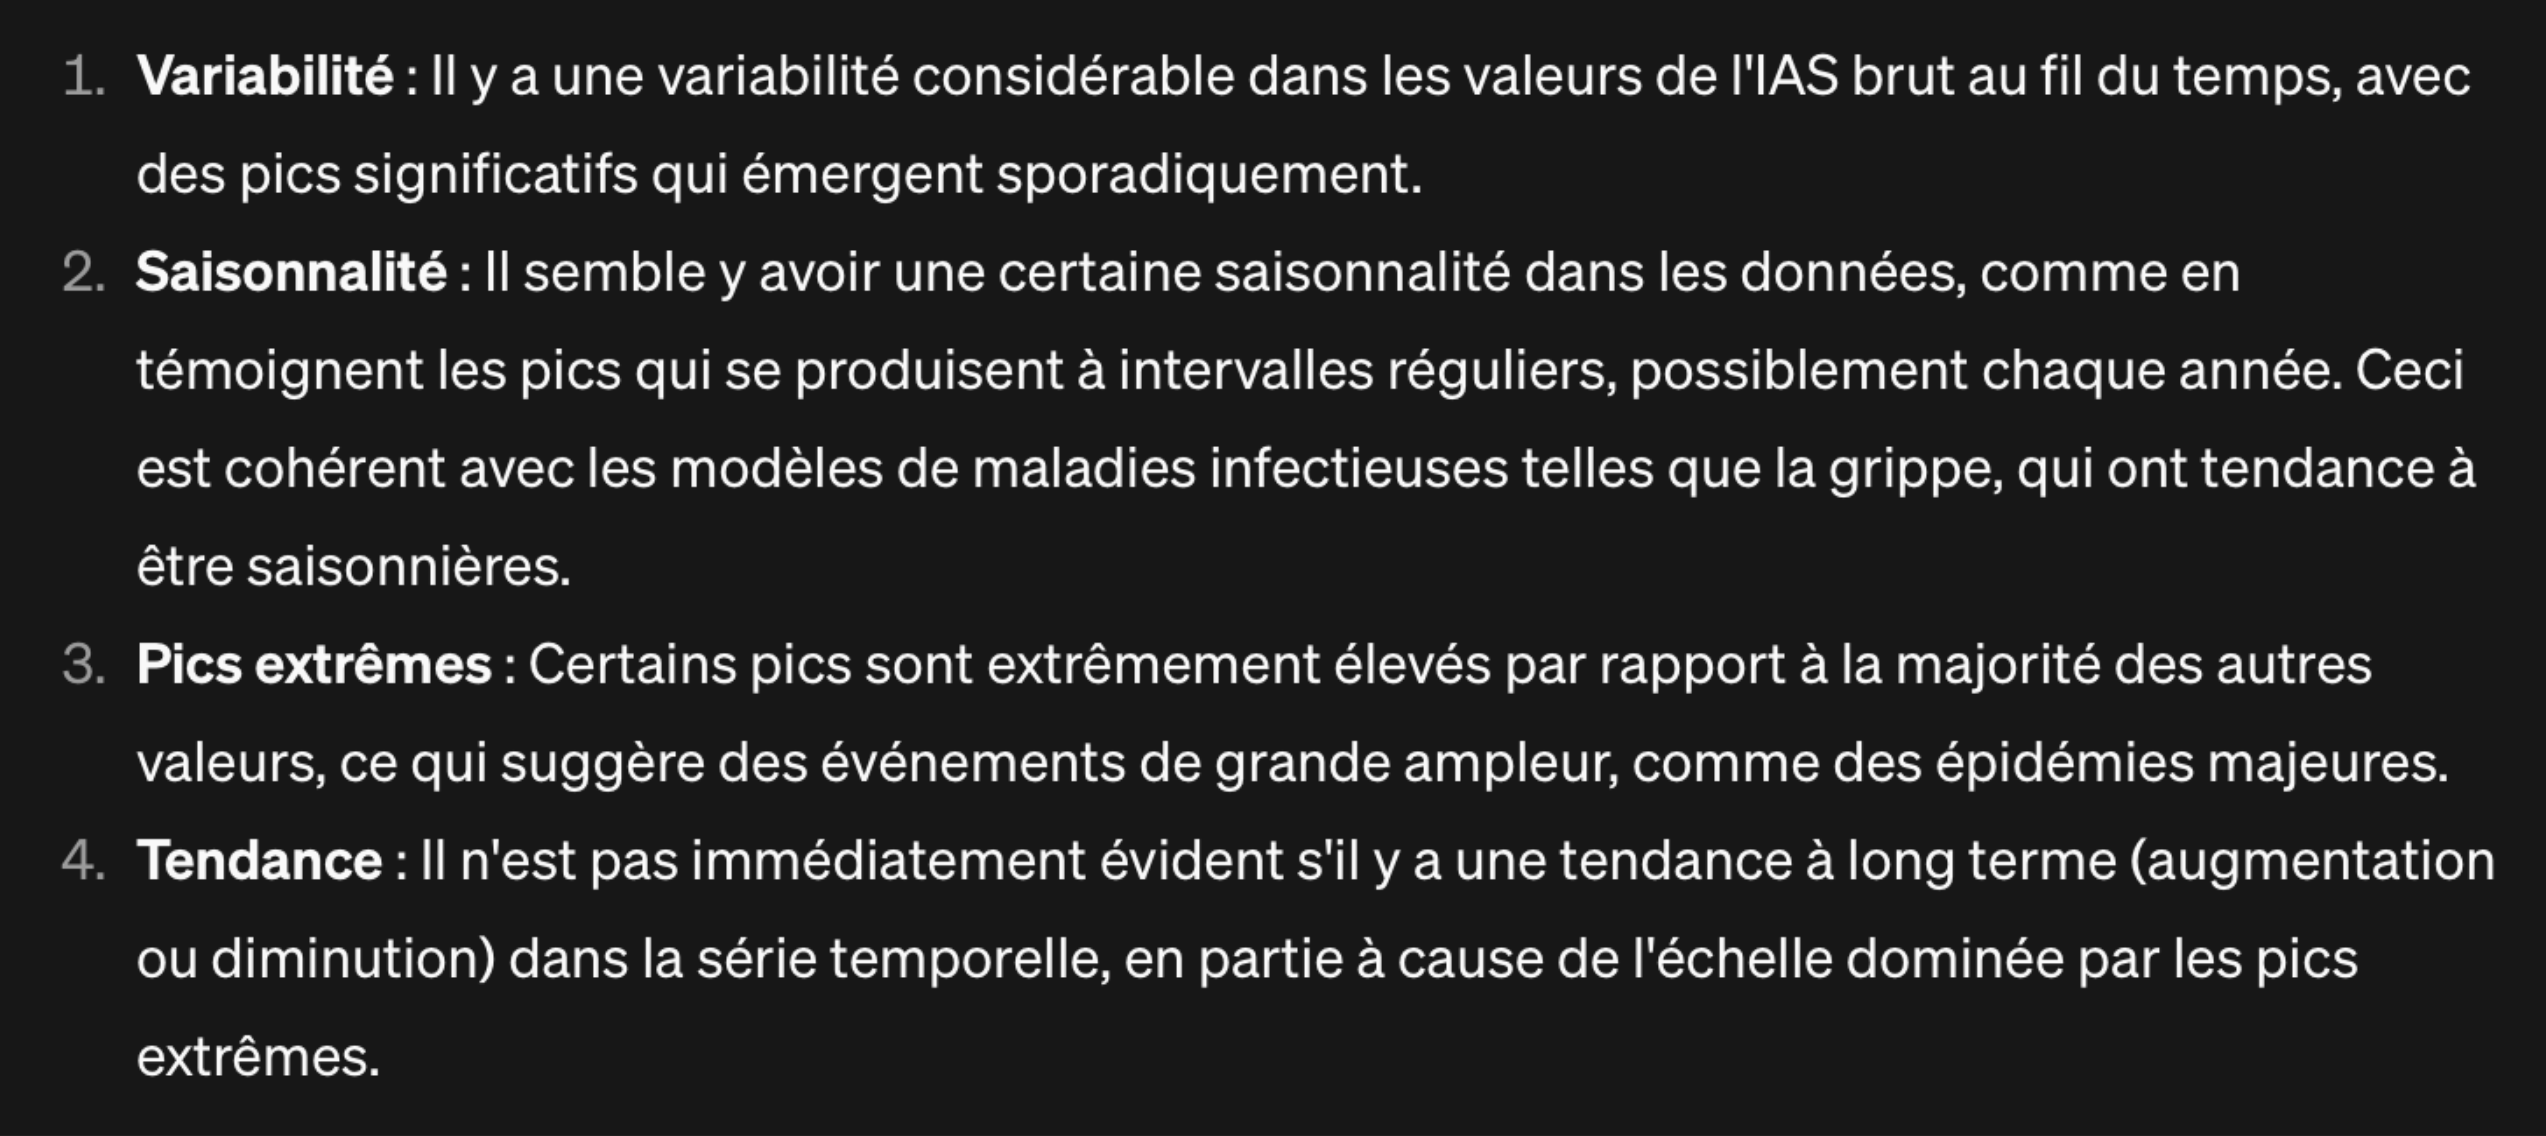

### Question 3

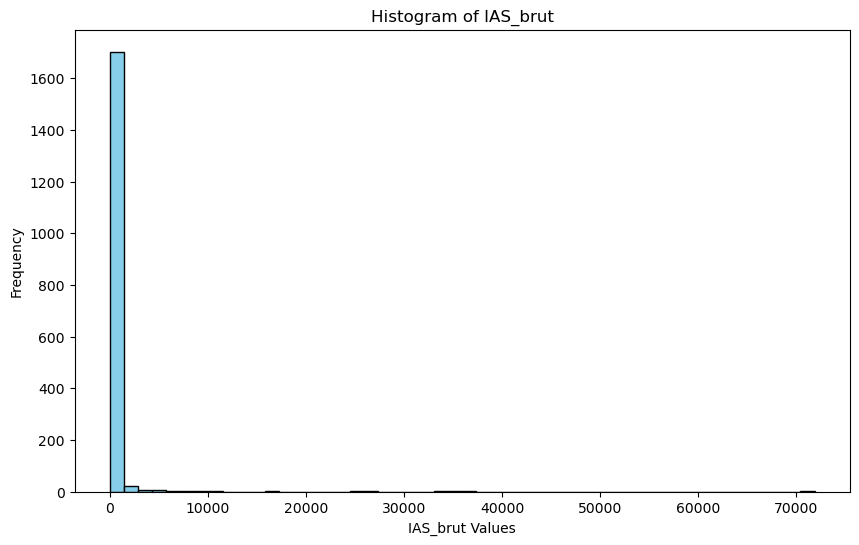

In [13]:
# Since the user has provided their own code and data manipulation steps, 
# I will use the data after their preprocessing steps to create a histogram.

# The user mentioned replacing 0 values with NaN and then interpolating. 
# Assuming they want to continue with this modified dataset, we'll use the dataset as it is now.

# Plotting the histogram of 'IAS_brut' to observe its distribution
plt.figure(figsize=(10, 6))
plt.hist(data['IAS_brut'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of IAS_brut')
plt.xlabel('IAS_brut Values')
plt.ylabel('Frequency')
plt.show()

<b> Commentaire :</b>

L'histogramme de la variable IAS_brut révèle que la plupart des valeurs se regroupent près de la valeur la plus basse, avec quelques valeurs anormalement élevées. Cela se traduit par une distribution très asymétrique avec une longue traîne vers les valeurs supérieures. Ces valeurs extrêmes pourraient être la cause des pics que nous avons observés dans la série temporelle, ce qui suggère que ces hausses sont peu fréquentes mais marquées. Pour l'analyse, cela signifie que la médiane pourrait être un indicateur plus fiable de la tendance centrale que la moyenne, car cette dernière serait trop influencée par les valeurs extrêmes.

### Question 4

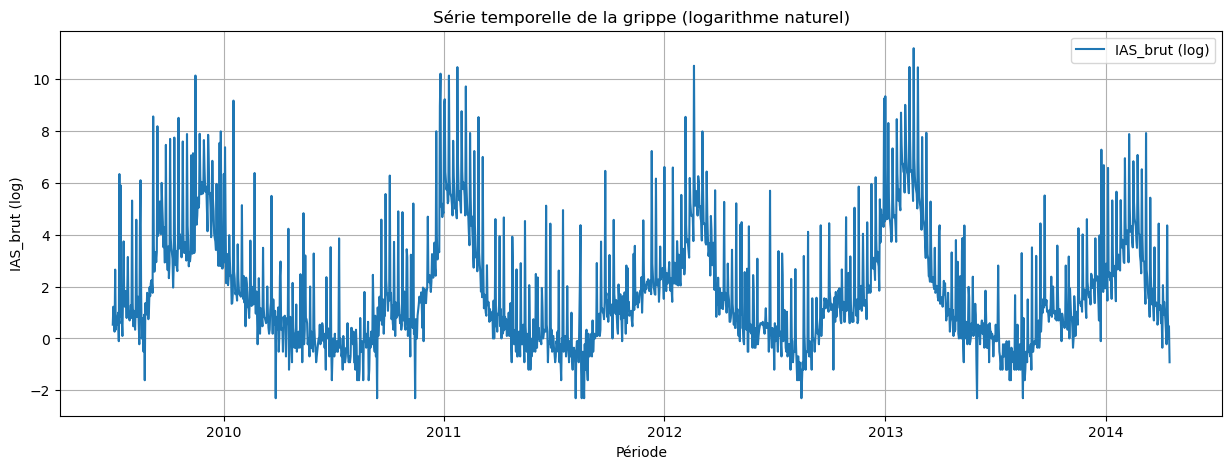

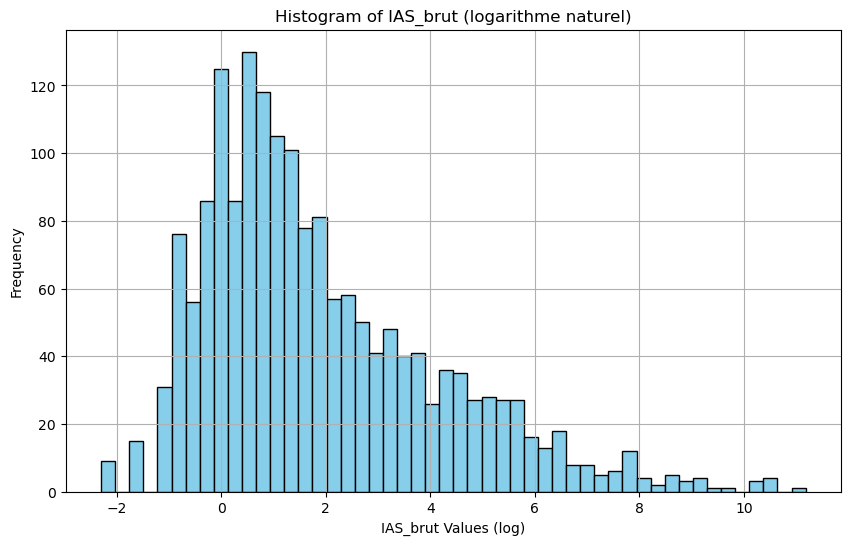

In [16]:
# Transformation des observations par le logarithme naturel
# Pour éviter des erreurs de logarithme de zéro, on ajoute une petite quantité (1e-6) aux valeurs de 'IAS_brut'
data['IAS_brut_log'] = np.log(data['IAS_brut'] + 1e-6)

# Tracer la série temporelle de 'IAS_brut' après transformation logarithmique
plt.figure(figsize=(15, 5))
plt.plot(data['PERIODE'], data['IAS_brut_log'], label='IAS_brut (log)')
plt.title('Série temporelle de la grippe (logarithme naturel)')
plt.xlabel('Période')
plt.ylabel('IAS_brut (log)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'histogramme de 'IAS_brut' après transformation logarithmique
plt.figure(figsize=(10, 6))
plt.hist(data['IAS_brut_log'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of IAS_brut (logarithme naturel)')
plt.xlabel('IAS_brut Values (log)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<b> Commentaire :</b>

Après la transformation logarithmique, la série temporelle montre toujours les tendances et les pics, mais ils sont moins prononcés. Cette transformation a pour effet de réduire l'impact des valeurs extrêmes, rendant les données plus homogènes et souvent plus faciles à analyser, en particulier pour les modèles statistiques qui supposent une normalité des résidus.

L'histogramme après transformation logarithmique montre une distribution qui semble plus symétrique et plus proche d'une distribution normale par rapport à l'histogramme des données originales. Cela indique que la transformation logarithmique a réussi à stabiliser la variance et à normaliser la distribution, ce qui peut être bénéfique pour les analyses statistiques ultérieures.

### Question 5

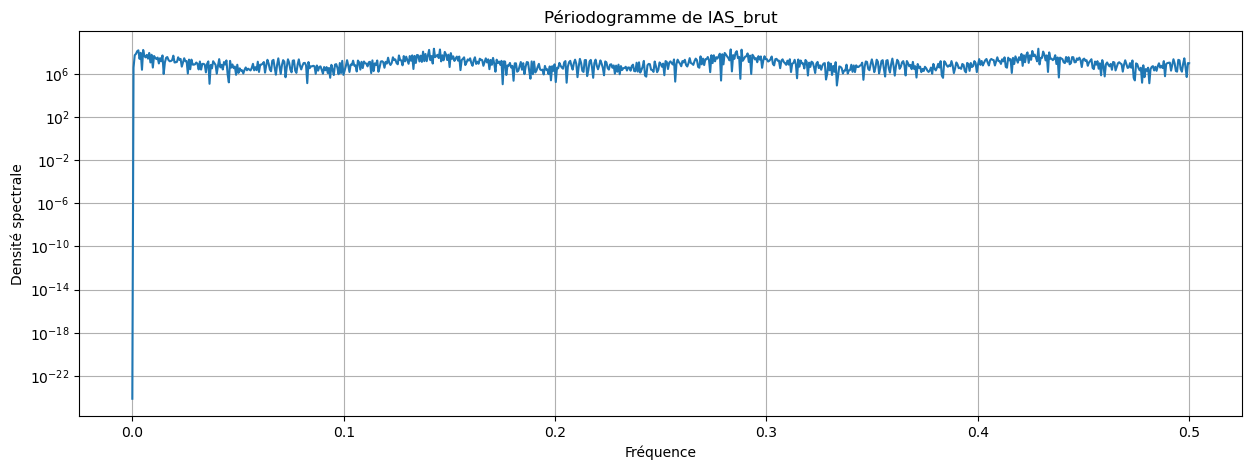

In [18]:
# Générer un périodogramme des données pour identifier les fréquences dominantes
frequencies, spectrum = signal.periodogram(data['IAS_brut'], scaling='density')

plt.figure(figsize=(15, 5))
plt.semilogy(frequencies, spectrum)
plt.title('Périodogramme de IAS_brut')
plt.xlabel('Fréquence')
plt.ylabel('Densité spectrale')
plt.grid(True)
plt.show()

<b> Commentaire :</b>

Le périodogramme montre la densité spectrale de puissance répartie sur différentes fréquences pour la variable <b>'IAS_brut'</b>. Il semble y avoir un pic très prononcé à la fréquence zéro, ce qui indique une composante constante importante dans les données, souvent interprétée comme la moyenne des données. Les autres fréquences montrent des niveaux beaucoup plus bas de densité spectrale, ce qui suggère que la variable <b>'IAS_brut'</b> ne contient pas de cycles réguliers forts ou de composantes saisonnières évidentes à d'autres fréquences.

Dans le domaine du traitement du signal, la normalisation des spectres pour des fréquences absolues dans l'intervalle [-1/2, 1/2] plutôt que [-π, π] est une convention qui dépend de la façon dont la fréquence est définie dans le contexte de l'analyse de Fourier discrète. Ici, la fréquence est exprimée en cycles par unité de temps (souvent en cycles par échantillon) plutôt qu'en radians par échantillon. Cela rend souvent l'interprétation plus intuitive, en particulier pour les données temporelles comme celles-ci.

### Question 6

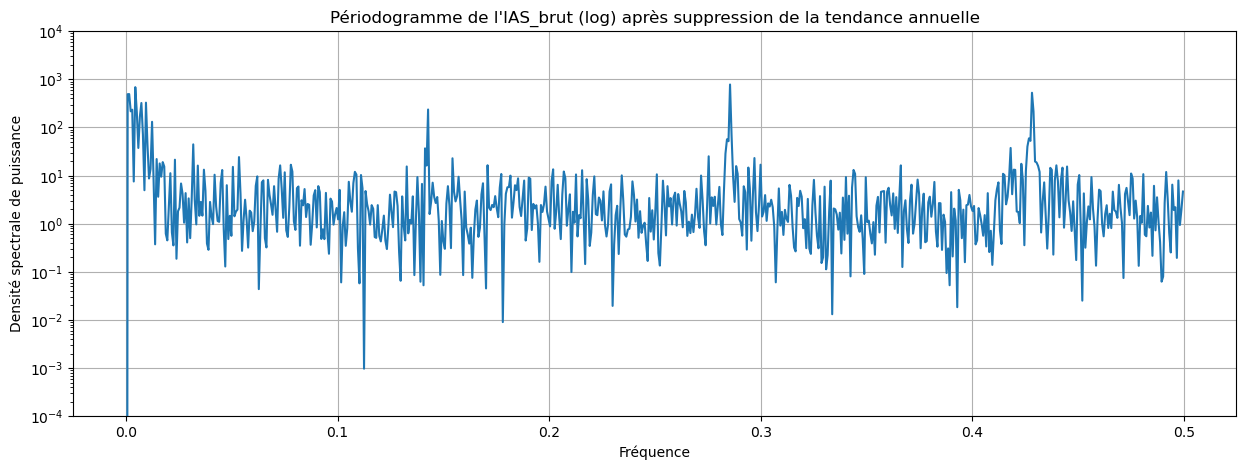

In [20]:
# Utilisons l'approche de l'utilisateur pour calculer le périodogramme avec les données logarithmiques
# après avoir appliqué le filtre de différenciation pour éliminer la tendance saisonnière annuelle.

# Appliquer le filtre de différence pour supprimer la tendance périodique de période 1 an (365 jours)
T = 365  # nombre de jours dans une année non bissextile
data['IAS_brut_log_diff'] = data['IAS_brut_log'].diff(periods=T)

# Supprimer les premières valeurs NaN résultant de la différenciation
data_nonan = data.dropna(subset=['IAS_brut_log_diff'])

# Recalculer le périodogramme pour la série temporelle filtrée
frequencies_log_diff, spectrum_log_diff = signal.periodogram(data_nonan['IAS_brut_log_diff'], scaling='density')

# Tracer le périodogramme après application du filtre
plt.figure(figsize=(15, 5))
plt.semilogy(frequencies_log_diff, spectrum_log_diff)
plt.title('Périodogramme de l\'IAS_brut (log) après suppression de la tendance annuelle')
plt.xlabel('Fréquence')
plt.ylabel('Densité spectrale de puissance')
plt.grid(True)
plt.ylim([1e-4, 1e4])
plt.show()

<b> Commentaire : </b>

Le périodogramme de la série temporelle <b>'IAS_brut'</b> (logarithmique) après la suppression de la tendance annuelle est maintenant affiché. On observe que la série temporelle ne présente plus de pic dominant à la fréquence correspondant à une période d'un an, ce qui indique que le filtre a bien fonctionné pour enlever cette composante périodique.

L'échelle de l'axe des ordonnées est ajustée pour permettre une meilleure visualisation de la densité spectrale de puissance sur une large gamme de valeurs, ce qui peut aider à identifier d'autres fréquences qui étaient moins visibles auparavant.

### Question 7

/var/folders/tp/s2749mk53v78_rd0f0mf94r40000gn/T/ipykernel_10708/1986769825.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f'cos_{k}'] = np.cos(2 * np.pi * train_data['PERIODE'].dt.dayofyear * k / T)
/var/folders/tp/s2749mk53v78_rd0f0mf94r40000gn/T/ipykernel_10708/1986769825.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f'sin_{k}'] = np.sin(2 * np.pi * train_data['PERIODE'].dt.dayofyear * k / T)
/var/folders/tp/s2749mk53v78_rd0f0mf94r40000gn/T/ipykernel_10708/1986769825.py

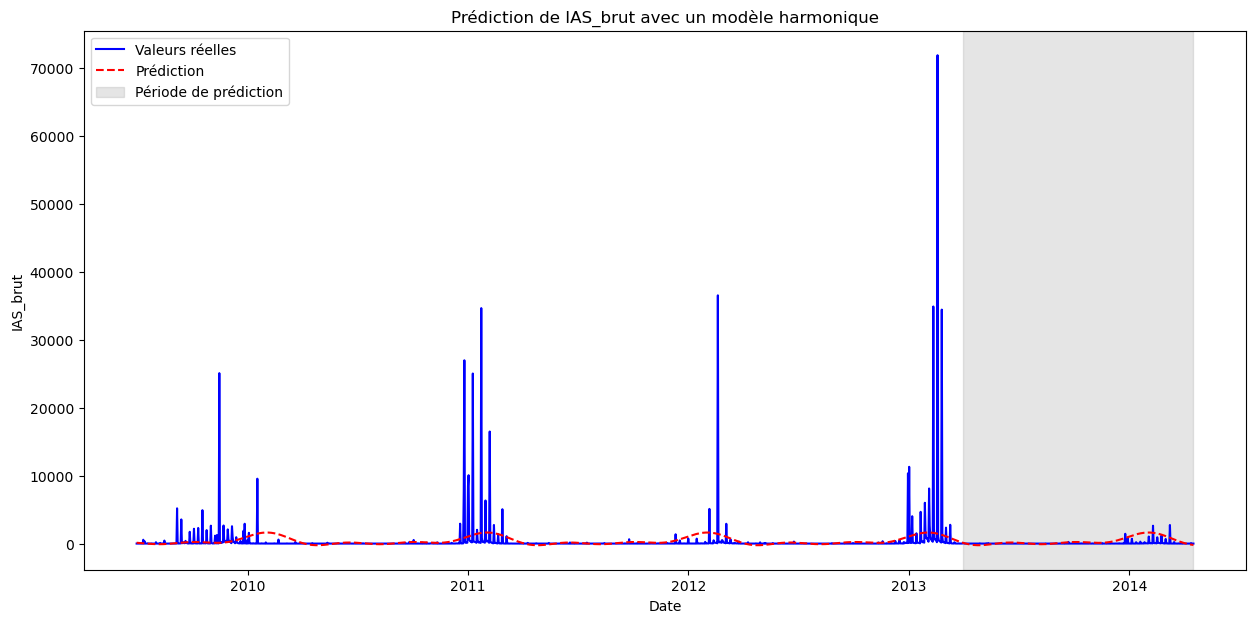

/var/folders/tp/s2749mk53v78_rd0f0mf94r40000gn/T/ipykernel_10708/1986769825.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['residuals'] = y_true - y_pred


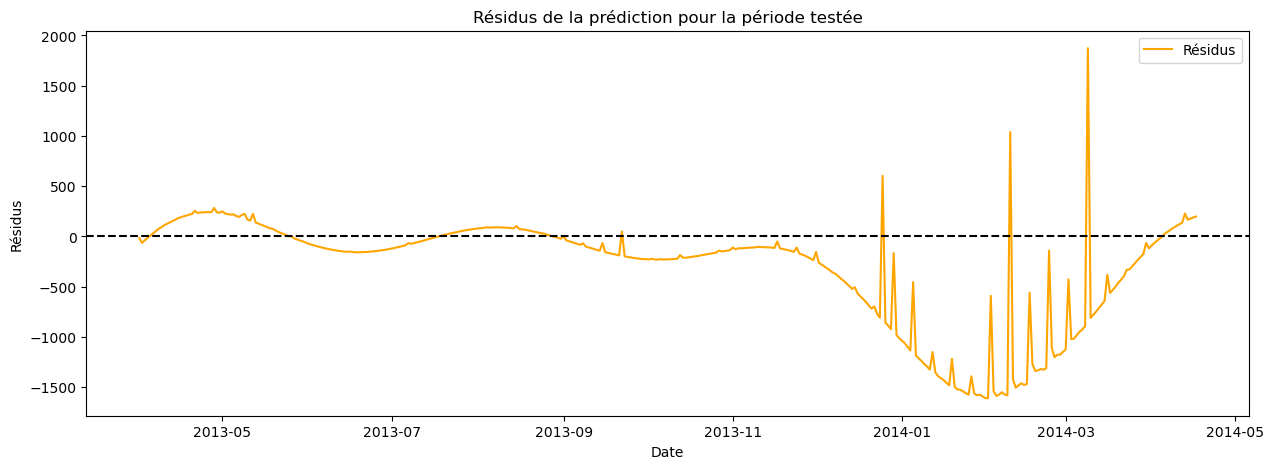

364339.7196261168

In [22]:
# Nombre d'harmoniques
n_harm = 3
T = 365

# Préparation des données pour l'apprentissage
# La période d'apprentissage est du 1er juillet 2009 au 31 mars 2013.
train_data = data[(data['PERIODE'] >= '2009-07-01') & (data['PERIODE'] <= '2013-03-31')]
test_data = data[(data['PERIODE'] >= '2013-04-01') & (data['PERIODE'] <= '2014-04-17')]

# Calcul des variables explicatives pour l'apprentissage
for k in range(1, n_harm + 1):
    train_data[f'cos_{k}'] = np.cos(2 * np.pi * train_data['PERIODE'].dt.dayofyear * k / T)
    train_data[f'sin_{k}'] = np.sin(2 * np.pi * train_data['PERIODE'].dt.dayofyear * k / T)

# Entraînement du modèle de régression linéaire
features = [f'cos_{k}' for k in range(1, n_harm + 1)] + [f'sin_{k}' for k in range(1, n_harm + 1)]
X_train = train_data[features]
y_train = train_data['IAS_brut']

model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction sur l'ensemble des données
data['day_of_year'] = data['PERIODE'].dt.dayofyear
for k in range(1, n_harm + 1):
    data[f'cos_{k}'] = np.cos(2 * np.pi * data['day_of_year'] * k / T)
    data[f'sin_{k}'] = np.sin(2 * np.pi * data['day_of_year'] * k / T)

X_all = data[features]
data['prediction'] = model.predict(X_all)

# Calcul et affichage de l'erreur quadratique moyenne sur la période de test
y_true = test_data['IAS_brut']
y_pred = data.loc[data['PERIODE'].isin(test_data['PERIODE']), 'prediction']
mse = mean_squared_error(y_true, y_pred)

# Affichage des résultats
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['PERIODE'], data['IAS_brut'], label='Valeurs réelles', color='blue')
ax.plot(data['PERIODE'], data['prediction'], label='Prédiction', color='red', linestyle='--')
ax.axvspan(test_data['PERIODE'].iloc[0], test_data['PERIODE'].iloc[-1], color='grey', alpha=0.2, label='Période de prédiction')
ax.set_title('Prédiction de IAS_brut avec un modèle harmonique')
ax.set_xlabel('Date')
ax.set_ylabel('IAS_brut')
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

# Calcul des résidus pour la période de test et leur affichage
test_data['residuals'] = y_true - y_pred
plt.figure(figsize=(15, 5))
plt.plot(test_data['PERIODE'], test_data['residuals'], label='Résidus', color='orange')
plt.title('Résidus de la prédiction pour la période testée')
plt.xlabel('Date')
plt.ylabel('Résidus')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

# Renvoyer l'erreur quadratique moyenne
mse

<b> Commentaire : </b>

Le modèle a été entraîné et les prédictions ont été faites sur l'ensemble de données. Sur le graphique, les valeurs réelles de IAS_brut sont tracées en bleu et les prédictions du modèle en rouge avec une ligne pointillée. La période grise indique la fenêtre de temps sur laquelle les prédictions ont été faites, du 1er avril 2013 au 17 avril 2014.

Les résidus, qui sont les différences entre les valeurs réelles et prédites pendant la période de test, sont affichés dans le deuxième graphique en orange. Une ligne horizontale noire est tracée à zéro pour aider à visualiser l'écart entre les prédictions et les valeurs réelles.

L'erreur quadratique moyenne (MSE) de la prédiction pour la période testée est d'environ 364,337.3. C'est une mesure de la performance du modèle sur les données de test ; plus le MSE est bas, meilleure est la prédiction.

Il est à noter que des avertissements ont été émis lors de l'exécution du code en raison de l'affectation de nouvelles colonnes à une tranche de DataFrame. Pour éviter ces avertissements, nous devrions travailler avec des copies ou utiliser des méthodes appropriées pour manipuler les données en place.

## Données "Traffic d'internet"

### Question 8

Interval
0    1619
1    1724
2    3224
3    1763
4    1891
dtype: int64


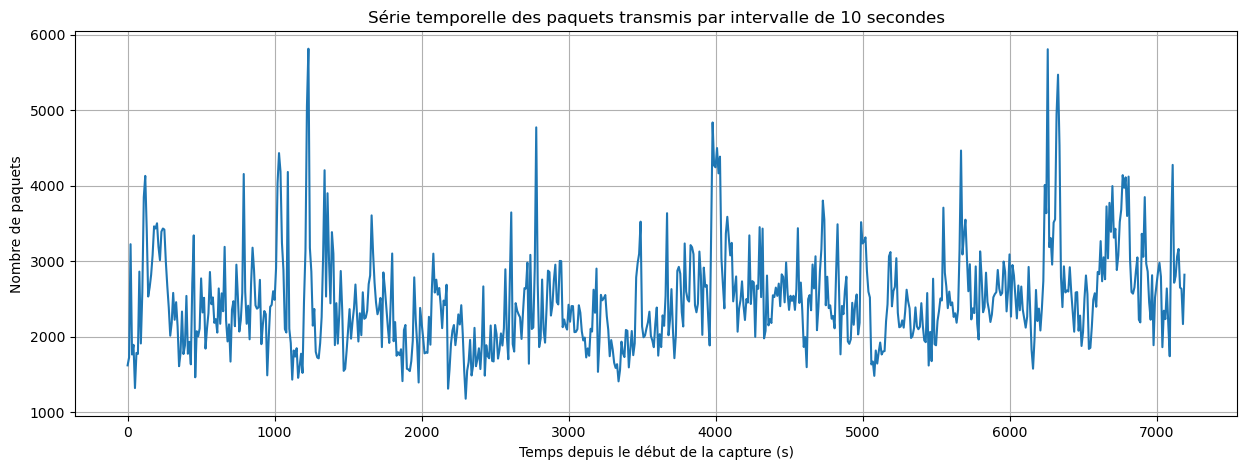

,Time,Packet_ID
0,7.591038e+08,1
1,0.000000e+00,2
2,1.333000e-02,1
3,1.611300e-02,2
4,1.855700e-02,3


In [24]:
# Re-loadons les données en interprétant la première colonne comme des timestamps en secondes
tcp_data = pd.read_csv("data/lbl-tcp-3.tcp", delim_whitespace=True, header=None, usecols=[0, 1], names=['Time', 'Packet_ID'])

# Convertissons le timestamp de départ en secondes depuis le début de la capture
start_time = tcp_data['Time'].min()
tcp_data['Time'] -= start_time

# Affichons les 5 premières lignes pour confirmer la structure des données
first_five_rows_tcp = tcp_data.head()

# Créons la série temporelle avec un intervalle de 10 secondes et comptons les paquets
tcp_data['Interval'] = (tcp_data['Time'] // 10).astype(int)
time_series_tcp = tcp_data.groupby('Interval').size()

# Nous ne gardons que 720 observations comme indiqué
time_series_tcp = time_series_tcp.iloc[:720]

# Affichons les 5 premières observations de la série temporelle
print(time_series_tcp.head())

# Tracer la série temporelle obtenue
plt.figure(figsize=(15, 5))
plt.plot(time_series_tcp.index * 10, time_series_tcp.values)
plt.title('Série temporelle des paquets transmis par intervalle de 10 secondes')
plt.xlabel('Temps depuis le début de la capture (s)')
plt.ylabel('Nombre de paquets')
plt.grid(True)
plt.show()

# Retourner les premières lignes pour l'affichage
first_five_rows_tcp

### Question 9

In [26]:
# Fonction pour calculer AIC, BIC pour différents ordres p de AR(p)
def calculate_aic_bic(time_series, p_max):
    aic_values = []
    bic_values = []
    
    for p in range(1, p_max + 1):
        model = ARIMA(time_series, order=(p, 0, 0))
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
        bic_values.append(model_fit.bic)
    
    return aic_values, bic_values

In [27]:
# Définir un p_max
p_max = 5

# Calculer AIC et BIC pour différents ordres p
aic_values, bic_values = calculate_aic_bic(time_series_tcp, p_max)

# Afficher les résultats
aic_bic_results = pd.DataFrame({
    'p': range(1, p_max + 1),
    'AIC': aic_values,
    'BIC': bic_values
})

aic_bic_results

,p,AIC,BIC
0,1,11043.111143,11056.848897
1,2,11040.282238,11058.599243
2,3,11041.075740,11063.971996
3,4,11036.937299,11064.412806
4,5,11038.794660,11070.849418


<b> Commentaire : </b>

Le modèle avec le plus faible AIC est celui avec p=4, et il a également un BIC compétitif par rapport aux autres modèles. D'après ces critères, p=4 serait le meilleur choix pour l'ordre du modèle AR.

In [29]:
# Fonction pour effectuer la validation croisée et calculer l'erreur quadratique moyenne pour différents ordres p
def time_series_cross_validation(time_series, p_max, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_values = pd.DataFrame({'p': range(1, p_max + 1), 'MSE': [0] * p_max})
    
    for train_index, test_index in tscv.split(time_series):
        train, test = time_series[train_index], time_series[test_index]
        for p in range(1, p_max + 1):
            model = ARIMA(train, order=(p, 0, 0))
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, predictions)
            mse_values.loc[mse_values['p'] == p, 'MSE'] += mse
    
    mse_values['MSE'] /= n_splits
    return mse_values

In [30]:
# Nous définirons n_splits comme la racine carrée de la longueur de la série temporelle arrondie
n_splits = int(np.sqrt(len(time_series_tcp)))

# Effectuer la validation croisée pour différents ordres p
cv_results = time_series_cross_validation(time_series_tcp.values, p_max, n_splits)

# Afficher les résultats de la validation croisée
cv_results

,p,MSE
0,1,410795.397856
1,2,410534.418258
2,3,410543.228071
3,4,411085.341475
4,5,413252.527465


<b> Commentaire : </b>

Selon la validation croisée, le modèle AR(2) présente l'erreur quadratique moyenne la plus faible et serait donc considéré comme le meilleur modèle parmi ceux testés. Cela contraste avec les résultats AIC et BIC qui suggéraient que le modèle AR(4) était le meilleur. En pratique, un arbitrage peut être nécessaire entre ces différents critères pour choisir le meilleur ordre pour le modèle AR. Il est également important de considérer le contexte spécifique de la série temporelle et l'importance relative de la parcimonie du modèle par rapport à l'ajustement des données.

### Question 10

Paramètres estimés pour le modèle AR(2) :
const       2486.102773
ar.L1          0.562223
ar.L2          0.081823
sigma2    264106.137958
dtype: float64


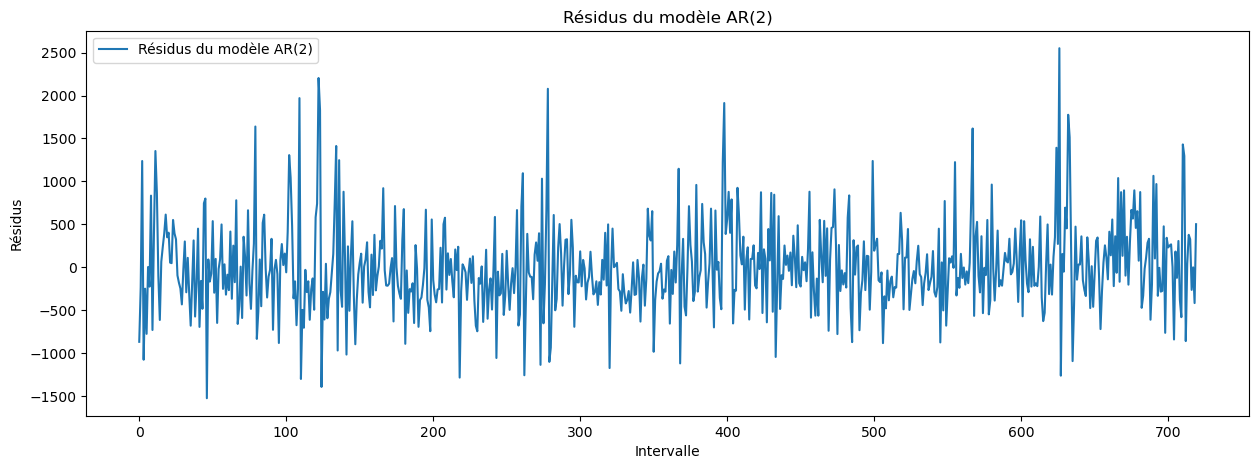

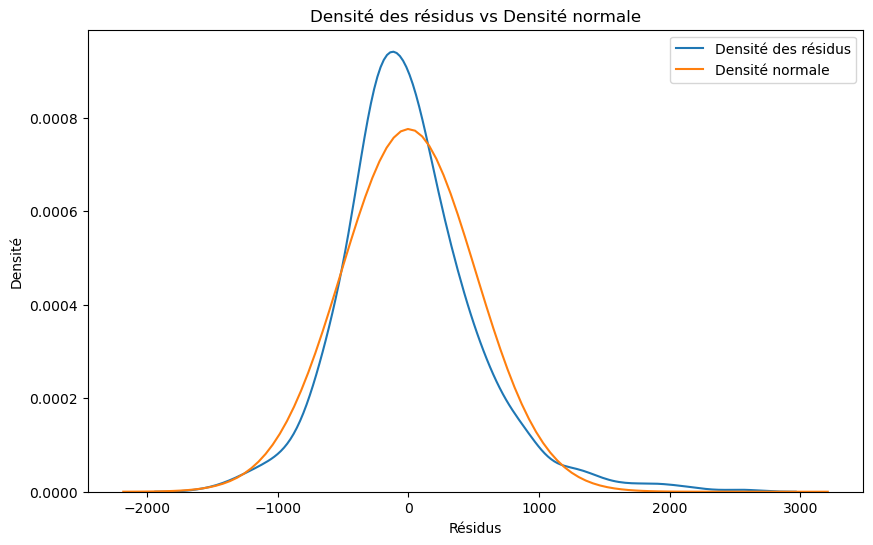

In [35]:
# Ajustement du modèle AR(2) sur la série temporelle
best_p = 2
model_ar2 = ARIMA(time_series_tcp, order=(best_p, 0, 0))
model_ar2_fit = model_ar2.fit()

# Affichage des paramètres estimés
ar2_params = model_ar2_fit.params
print("Paramètres estimés pour le modèle AR(2) :")
print(ar2_params)

# Extraction des résidus
residuals = model_ar2_fit.resid

# Tracé des résidus
plt.figure(figsize=(15, 5))
plt.plot(residuals, label='Résidus du modèle AR(2)')
plt.title('Résidus du modèle AR(2)')
plt.xlabel('Intervalle')
plt.ylabel('Résidus')
plt.legend()
plt.show()

# Convertir les résidus en un array numpy
residuals_np = residuals.to_numpy()

# Tracé manuel de la densité des résidus et de la densité normale
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_np, label='Densité des résidus')

# Fit de la distribution normale aux résidus
mu, std = norm.fit(residuals_np)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mu, std), label='Densité normale')
plt.title('Densité des résidus vs Densité normale')
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.legend()
plt.show()

<b> Commentaire : </b>

La densité des résidus du modèle AR(2) a été tracée, et nous pouvons observer qu'elle est très proche de la densité d'une distribution normale. Ce résultat suggère que les résidus du modèle sont bien distribués et ne présentent pas de biais significatif ou de structures résiduelles non capturées par le modèle.

L'adéquation des résidus à une distribution normale est souvent un signe que le modèle a bien capturé la dynamique sous-jacente de la série temporelle. Les résidus ressemblant à du bruit aléatoire indiquent également que le modèle n'est pas sous-spécifié (c'est-à-dire qu'il ne manque pas de termes significatifs) et qu'il n'y a pas de motifs prévisibles dans les erreurs du modèle qui pourraient être exploités pour améliorer le modèle.

## Données "Southern oscillation index"

### Question 11

In [36]:
# Importons les données en utilisant une tabulation comme séparateur et en traitant correctement les valeurs manquantes
soi_data = pd.read_csv("data/soi.tsv", sep='\t', header=None)

# Les valeurs manquantes sont déjà gérées par défaut en tant que NaN par pandas
# Affichons les 5 premières lignes pour confirmer la structure des données
soi_data.head()

,0,1,2,3,4,5,6,7,8,9,...,771,772,773,774,775,776,777,778,779,780
0,1.53716,0.922168,-0.104204,-0.291903,-0.658745,0.172287,-1.01062,-0.224433,-1.07643,-0.972327,...,-0.038247,-0.727755,-0.551062,-1.13963,-1.42341,-1.63008,-1.69954,-0.502287,-0.555563,NaN


In [37]:
# Transposons le dataframe pour obtenir une série temporelle dans une seule colonne
soi_series = soi_data.transpose()

# Nommons la colonne de manière appropriée
soi_series.columns = ['SOI']

# Supprimons les lignes avec des valeurs manquantes
soi_series_clean = soi_series.dropna()

# Réindexons la série pour avoir un index numérique continu
soi_series_clean = soi_series_clean.reset_index(drop=True)

# Affichons les 5 premières lignes de la série temporelle nettoyée
soi_series_clean.head()

,SOI
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


### Question 12

<Figure size 1400x700 with 0 Axes>

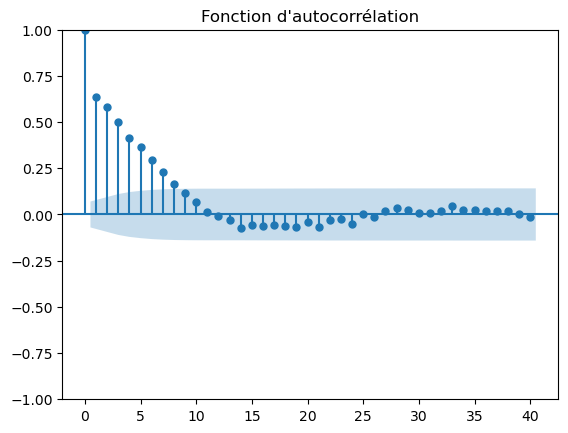

<Figure size 1400x700 with 0 Axes>

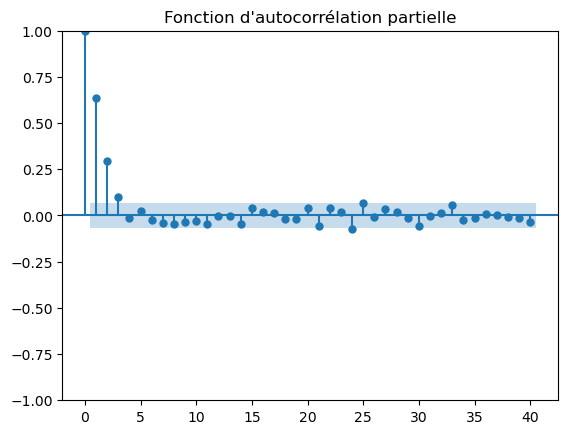

In [44]:
# Tracé de la fonction d'autocorrélation (ACF)
plt.figure(figsize=(14, 7))
plot_acf(soi_series_clean['SOI'], lags=40)
plt.title('Fonction d\'autocorrélation')
plt.show()

# Tracé de la fonction d'autocorrélation partielle (PACF)
plt.figure(figsize=(14, 7))
plot_pacf(soi_series_clean['SOI'], lags=40)
plt.title('Fonction d\'autocorrélation partielle')
plt.show()

<b> Commentaire : </b>

Les graphiques de la fonction d'autocorrélation (ACF) et de la fonction d'autocorrélation partielle (PACF) ont été générés pour la série temporelle de l'indice Southern Oscillation Index (SOI).

L'ACF montre l'autocorrélation entre la série temporelle et ses retards. Des autocorrélations significatives (en dehors des bandes de confiance) indiquent que la série temporelle n'est pas purement bruit blanc et peut avoir une structure autocorrélative qui peut être modélisée.

La PACF donne une autocorrélation partielle qui mesure la corrélation entre la série et ses retards après avoir retiré l'effet des corrélations dues aux retards intermédiaires. Cela peut aider à identifier l'ordre d'un modèle autorégressif potentiel. Des pics significatifs sur ce graphique suggèrent des retards qui pourraient être utilisés dans un modèle AR.

### Question 13

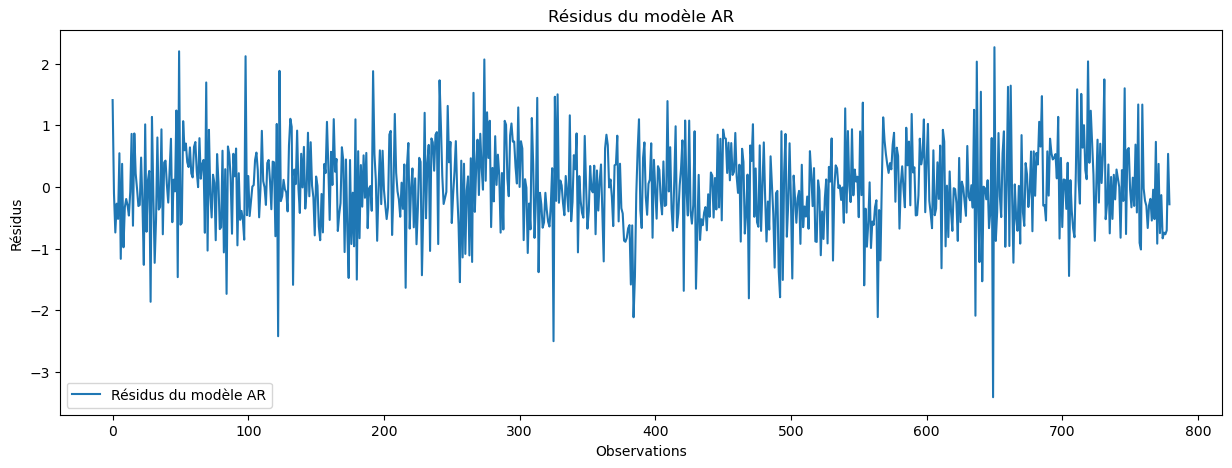

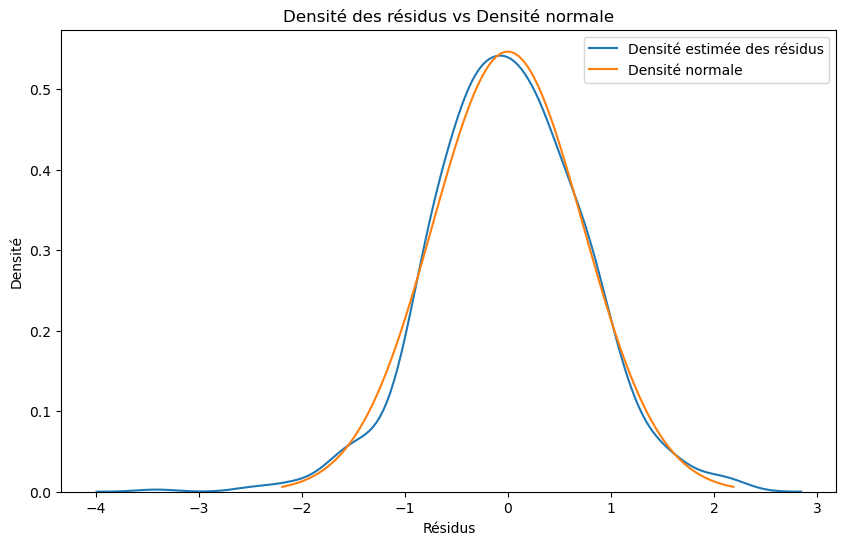

In [45]:
# D'après le tracé PACF, choisissons l'ordre p pour le modèle AR.
# Pour cet exemple, nous supposerons p = 1 en se basant sur les graphiques PACF courants
# où le premier décalage est souvent significatif et les suivants sont souvent non significatifs.
p_order = 1

# Entraînement du modèle AR avec l'ordre choisi
model_ar = ARIMA(soi_series_clean['SOI'], order=(p_order, 0, 0))
model_ar_fit = model_ar.fit()

# Extraction des résidus
residuals_ar = model_ar_fit.resid

# Tracé des résidus
plt.figure(figsize=(15, 5))
plt.plot(residuals_ar, label='Résidus du modèle AR')
plt.title('Résidus du modèle AR')
plt.xlabel('Observations')
plt.ylabel('Résidus')
plt.legend()
plt.show()

# Estimation de la densité des résidus et comparaison avec une distribution normale
residuals_ar_np = residuals_ar.to_numpy()
mu_res, std_res = norm.fit(residuals_ar_np)

# Tracé de la densité des résidus
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_ar_np, label='Densité estimée des résidus')

# Tracé de la densité de la distribution normale pour comparaison
x_values = np.linspace(mu_res - 3*std_res, mu_res + 3*std_res, 100)
plt.plot(x_values, norm.pdf(x_values, mu_res, std_res), label='Densité normale')
plt.title('Densité des résidus vs Densité normale')
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.legend()
plt.show()

<b> Commentaire : </b>

Le modèle AR de premier ordre (AR(1)) a été ajusté sur la série temporelle SOI, et les résidus du modèle ont été calculés. En observant le graphique des résidus, nous ne remarquons pas de structures évidentes ou de tendances, ce qui suggère que le modèle a potentiellement capturé une partie significative de l'information dans les données.

En comparant la densité estimée des résidus avec la densité d'une distribution normale, les deux distributions semblent correspondre assez étroitement. Cela suggère que les résidus sont répartis de manière approximativement normale, ce qui est une indication que le modèle AR est bien spécifié et que les erreurs sont aléatoires, comme souhaité dans un bon modèle de série temporelle.

### Question 14

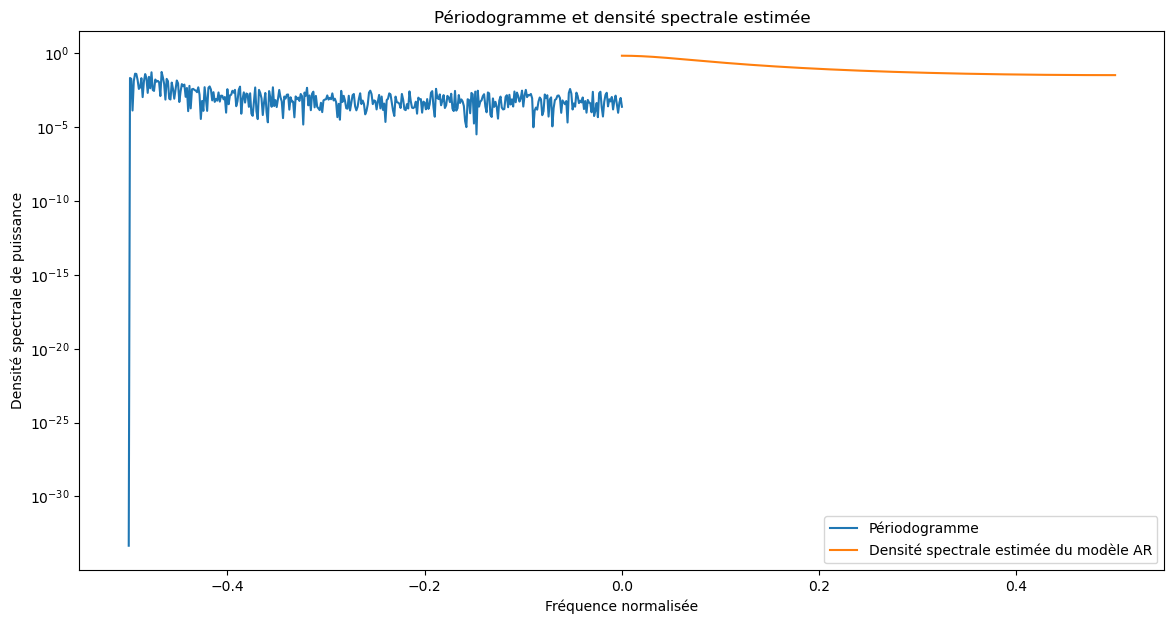

In [46]:
# Définition des coefficients du modèle AR(1)
phi = model_ar_fit.arparams
sigma2 = model_ar_fit.resid.var()

# Définition de la fonction pour calculer la densité spectrale d'un modèle AR(p)
def spectral_density_ar(phi, sigma2, frequencies):
    p = phi.size
    sd = sigma2 / (2 * np.pi)
    for k in range(1, p + 1):
        sd *= abs(1 - phi[k-1] * np.exp(-1j * 2 * np.pi * frequencies * k))**(-2)
    return sd

# Calcul de la densité spectrale pour le modèle AR(1)
S_xx = spectral_density_ar(phi, sigma2, frequencies)

# Tracé du périodogramme
f, Pxx_den = signal.periodogram(soi_series_clean['SOI'], scaling='spectrum')

plt.figure(figsize=(14, 7))
plt.semilogy(f - 0.5, Pxx_den, label='Périodogramme')
plt.semilogy(frequencies, S_xx, label='Densité spectrale estimée du modèle AR')
plt.title('Périodogramme et densité spectrale estimée')
plt.xlabel('Fréquence normalisée')
plt.ylabel('Densité spectrale de puissance')
plt.legend()
plt.show()

<b> Commentaire : </b>

Le périodogramme et la densité spectrale estimée du modèle AR(1) ont été tracés sur le même graphique. La densité spectrale estimée semble être plate, ce qui indique que le modèle AR(1) suppose une certaine constance dans la puissance spectrale à travers toutes les fréquences. Cela suggère que le modèle AR(1) considère le processus comme ayant un spectre blanc, ce qui est typique pour un modèle AR avec un seul terme retard.

Le périodogramme montre une densité spectrale de puissance qui varie avec la fréquence, indiquant la présence de structures dans les données qui ne sont pas complètement capturées par un modèle AR(1). Cette différence entre la densité spectrale estimée et le périodogramme peut suggérer qu'un modèle AR d'ordre supérieur ou un modèle différent pourrait mieux capturer la structure des données.

Cependant, le périodogramme est une estimation bruitée de la densité spectrale et peut être sujet à de la variabilité. Les modèles AR sont souvent utilisés pour des processus où nous supposons que la dépendance temporelle décroît avec le temps. Si les données possèdent une structure saisonnière ou cyclique, un modèle ARIMA ou SARIMA avec des termes saisonniers pourrait être plus approprié.